# How resilient are our models?
If we take many (>30) classifications of a galaxy and randomly pick 30, what model do we get, and how does this vary depending on the classifications we pick?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
print('Importing needed modules...')
import os
import json
import string
import numpy as np
import pandas as pd
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import lib.galaxy_utilities as gu
from lib.custom_progressbar import Progress
# import gzbuilderaggregation
# import gzbuilderaggregation.parse_annotation as pa
# import gzbuilderaggregation.average_shape_helpers as ash
import gzbuilder_analysis.aggregation as aggregation
from gzbuilder_analysis.aggregation import average_shape_helpers as ash
import gzbuilder_analysis.parsing as parsing
from descartes import PolygonPatch
from IPython.display import display, HTML, update_display
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

Importing needed modules...


In [3]:
print('Defining custom progress bar')
class progress():
  def __init__(self, initial_value=0, min_value=0, max_value=10):
      self.min = min_value
      self.max = max_value
      self.value = initial_value
      self.text = '{} / {}'.format(self.value, self.max)
      styles = ';'.join((
          'display:flex',
          'flex-direction:row',
          'align-items:center',
          'justify-content:center',
          'width:100%'
      ))
      self.container_html = '<div style="{}">{{}}</div>'.format(styles)
      self.text_html = '<h3 style="margin-right:20px">{}</h3>'
      self.bar_html = '<progress value={value} min={min} max={max} style="flex-grow:1" />'
      self.display_id = None
      self.show()
  def update(self, new_value, text=None):
      self.value = new_value
      self.text = text if text is not None else '{} / {}'.format(self.value, self.max)
      if self.display_id is not None:
        update_display(self, display_id=self.display_id)
      return self
  def _repr_html_(self):
      return self.container_html.format(
          self.text_html.format(self.text)
          + self.bar_html.format(**self.__dict__)
      )
  def show(self):
      self.display_id = ''.join(np.random.choice(list(string.ascii_lowercase), 30))
      display(self, display_id=self.display_id)

Defining custom progress bar


In [4]:
DR8ID = None # 588023240206516423 is method paper galaxy
N_SPLITS = 10

In [5]:
dr8ids, ss_ids, validation_ids = np.load('lib/duplicate_galaxies.npy').T

if DR8ID is None:
    DR8ID = np.random.choice(dr8ids)

ss_id, val_id = ss_ids[dr8ids == DR8ID][0], validation_ids[dr8ids == DR8ID][0]
print(ss_id, val_id)

20902061 21686590


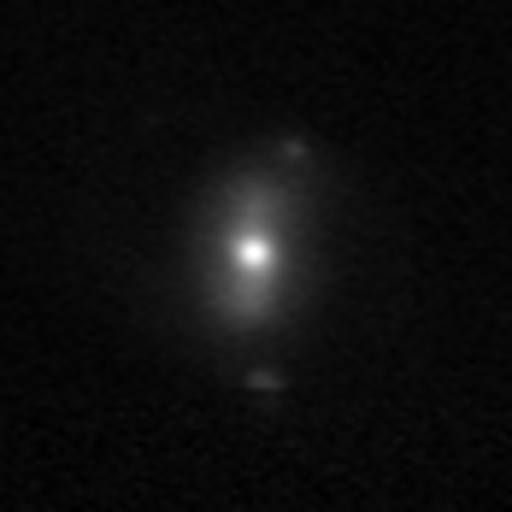

In [6]:
gal, angle = gu.get_galaxy_and_angle(ss_id)
pic_array = gu.get_image(ss_id)
psf = gu.get_psf(ss_id)
diff_data = gu.get_diff_data(ss_id)
pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
galaxy_data = np.array(diff_data['imageData'])[::-1]
size_diff = diff_data['width'] / diff_data['imageWidth']
display(pic_array)

In [7]:
cls = gu.classifications.query('subject_ids == {} | subject_ids == {}'.format(ss_id, val_id))

In [8]:
p = Progress(min_value=0, max_value=N_SPLITS)
results = []
for i in range(N_SPLITS):
    p.update(i)
    results.append(
        aggregation.make_model(
            cls.sample(30),
            gal,
            angle
        )
    )
p.update(i + 1, text='Complete!');

In [9]:
def get_pa_from_arms(arms):
    try:
        p = arms[0].get_parent()
        return p.get_pitch_angle(arms)
    except IndexError:
        return [np.nan, np.nan]

disk_df = pd.DataFrame([
    i[0]['disk'] for i in results if i[0]['disk'] is not None
])
bulge_df = pd.DataFrame([
    i[0]['bulge'] for i in results if i[0]['bulge'] is not None
])
bar_df = pd.DataFrame([
    i[0]['bar'] for i in results if i[0]['bar'] is not None
])
pa_df = pd.DataFrame([get_pa_from_arms(i[-1]) for i in results], columns=('pa', 'sigma_pa'))

if len(disk_df):
    display(HTML('<h3>Disc</h3>'))
    display(disk_df.describe())
if len(bulge_df):
    display(HTML('<h3>Bulge</h3>'))
    display(bulge_df.describe())
if len(bar_df):
    display(HTML('<h3>Bar</h3>'))
    display(bar_df.describe())
display(HTML('<h3>Spiral Pitch angle</h3>'))
display(pa_df.describe());

,axRatio,c,i0,n,rEff,roll
count,10.000000,10.0,10.000000,10.0,10.000000,10.000000
mean,0.571716,2.0,0.205138,1.0,61.623281,1.450628
std,0.032757,0.0,0.012366,0.0,8.104261,0.057860
min,0.518744,2.0,0.188095,1.0,52.301634,1.381798
25%,0.544374,2.0,0.195739,1.0,55.475094,1.399892
50%,0.578170,2.0,0.204253,1.0,61.330080,1.440307
75%,0.592424,2.0,0.210466,1.0,65.166260,1.501864
max,0.625645,2.0,0.227059,1.0,77.850201,1.539255


,axRatio,c,i0,n,rEff,roll
count,10.000000,10.0,10.000000,10.000000,10.000000,10.000000
mean,0.958237,2.0,0.805197,1.467290,13.476037,1.719516
std,0.031111,0.0,0.152690,0.212776,0.847730,0.329491
min,0.915194,2.0,0.561667,1.099231,12.478671,1.269786
25%,0.931487,2.0,0.675531,1.376667,12.772165,1.486268
50%,0.963739,2.0,0.808026,1.504583,13.317217,1.670749
75%,0.975744,2.0,0.936229,1.609250,14.069830,1.903792
max,1.000000,2.0,0.990000,1.741667,15.032604,2.282658


,axRatio,c,i0,n,rEff,roll
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,0.214259,1.972500,0.275833,0.825000,24.490187,1.558713
std,0.010759,0.103185,0.018733,0.239034,1.360545,0.024166
min,0.202797,1.883333,0.256667,0.466667,22.540619,1.522463
25%,0.209602,1.888333,0.264167,0.816667,24.063503,1.558713
50%,0.212747,1.956667,0.273333,0.940000,24.997814,1.570796
75%,0.217404,2.040833,0.285000,0.948333,25.424498,1.570796
max,0.228743,2.093333,0.300000,0.953333,25.424504,1.570796


,pa,sigma_pa
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


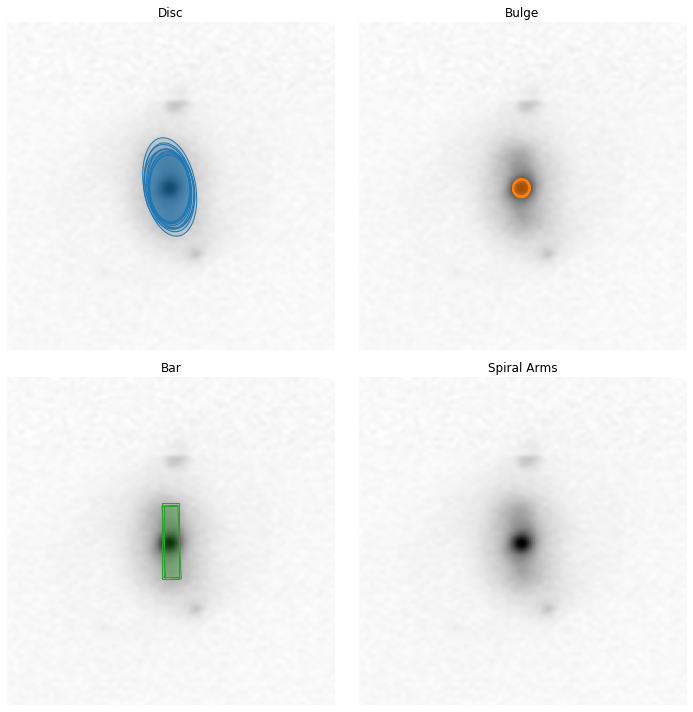

In [10]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
axs = (ax0, ax1, ax2, ax3)
titles = ('Disc', 'Bulge', 'Bar', 'Spiral Arms')
for i, ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.imshow(pic_array, origin='lower', cmap='gray_r')
    ax.axis('off');

for agg_model, masks, arms in results:
    disk = ash.make_ellipse(agg_model['disk'])
    bulge = ash.make_ellipse(agg_model['bulge'])
    bar = ash.make_box(agg_model['bar'])

    plt.imshow(pic_array, origin='lower', cmap='gray_r')
    for i, geom in enumerate((disk, bulge, bar)):
        plt.sca(axs[i])
        if geom is not None:
            p = PolygonPatch(geom, fc='none', ec='C{}'.format(i), zorder=2, lw=1)
            p2 = PolygonPatch(geom, fc='C{}'.format(i), ec='none', alpha=0.1, zorder=2, lw=2)
            plt.gca().add_patch(p)
            plt.gca().add_patch(p2)
    plt.sca(axs[-1])
    for i, arm in enumerate(arms):
        plt.plot(*arm.reprojected_log_spiral.T, c='r', 
                 linewidth=2, alpha=0.6)
plt.tight_layout()

## Scaling up

What do we observe when we expand this method to all the galaxies in the *validation subset*? The output from all the galaxies (ish) has been saved in `model-variances.pkl`, which we explore here:

In [11]:
df = pd.read_pickle('model-variances.pkl')
description_df = df.groupby(level=0).describe()

In [12]:
# description_df[[
#   ('{}_{}'.format(a, b), c)
#   for a in ('disk', 'bulge', 'bar')
#   for b in ('axRatio', 'rEff', 'roll') 
#   for c in ('mean', 'std', 'count') 
# ]]

In [13]:
plt.style.use('seaborn')

Using default galaxy
BRR mean and error: 9.4495 ± 1.7301
Sample mean and std.: 12.0523 ± 3.3263
10.774682390435599


Text(0.5, 0, 'Distribution of pitch angles from sample')

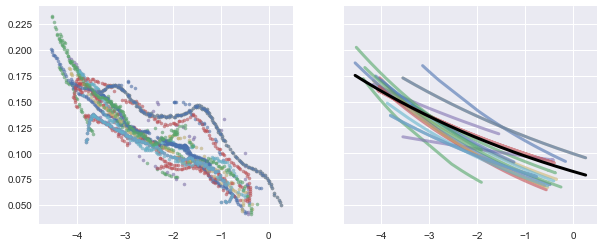

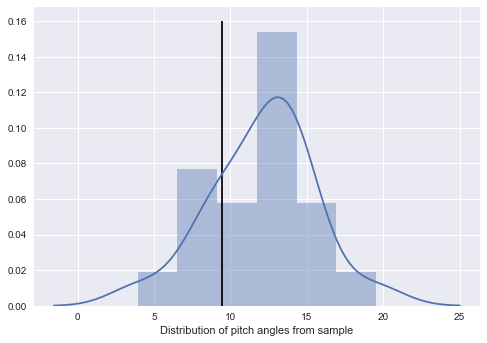

In [19]:
from gzbuilderspirals.oo import Arm
from gzbuilder_analysis.spirals import get_pitch_angle
from gzbuilder_analysis.spirals.fitting import get_log_spiral_pipeline

logsp_model = get_log_spiral_pipeline()
try:
  a = Arm.load('lib/spiral_arms/{}-0.pickle'.format(ss_id))
except OSError:
  print('Using default galaxy')
  a = Arm.load('lib/spiral_arms/20902040-0.pickle'.format(ss_id))
foo = []
f, ax = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))
plt.sca(ax[0])
plt.plot(a.t, a.R, 'k.', alpha=0.1)
for i in np.unique(a.groups):
  t = a.t[a.groups == i]
  R = a.R[a.groups == i]
  if len(t) < 10:
    continue
  pw = a.point_weights[a.groups == i]
  logsp_model.fit(np.expand_dims(t, 1), R,
                  bayesianridge__sample_weight=pw)
  Rp = logsp_model.predict(np.expand_dims(t, 1))
  plt.sca(ax[0])
  plt.plot(t, R, '.', c='C{}'.format(i), alpha=0.5)
  plt.sca(ax[1])
  plt.plot(t, Rp, linewidth=3, alpha=0.6, c='C{}'.format(i))
  br = logsp_model.named_steps['bayesianridge'].regressor_
  coef = br.coef_
  sigma = br.sigma_
  pa, sigma_pa, chirality = get_pitch_angle(
      coef[0],
      sigma[0, 0]
  )
  foo.append((pa, sigma_pa))
foo = np.array(foo)
plt.plot(*a.polar_logsp, 'k', linewidth=3)

print('BRR mean and error: {:.4f} ± {:.4f}'.format(a.pa, a.sigma_pa))
print('Sample mean and std.: {:.4f} ± {:.4f}'.format(
  foo[:, 0].mean(),
  foo[:, 0].std()
))
print(np.sqrt(np.sum(foo[:, 1]**2)))
plt.figure()
sns.distplot(pd.Series(foo[:, 0]))
plt.vlines(a.pa, 0, 0.16)
plt.xlabel('Distribution of pitch angles from sample')

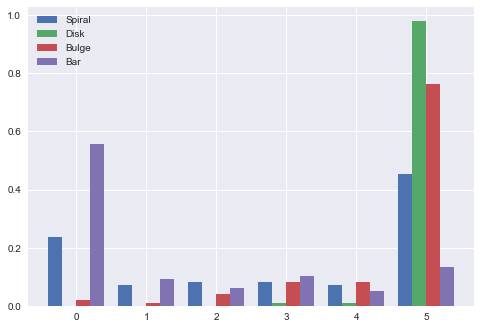

In [15]:
plt.hist(
  np.stack((
    description_df[('pa', 'count')].values,
    description_df[('disk_axRatio', 'count')].values,
    description_df[('bulge_axRatio', 'count')].values,
    description_df[('bar_axRatio', 'count')].values,
  ), axis=-1),
  bins=np.arange(-0.5, 6.5),
  stacked=False, align='mid',
  density=True,
  label=('Spiral', 'Disk', 'Bulge', 'Bar')
)
plt.legend();